In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import PosixPath
path = PosixPath('../input')

In [3]:
import pandas as pd
df = pd.read_csv(path/'train.csv')

In [4]:
df.id = 'train/train/' + df.id

In [5]:
df.head()

,id,has_cactus
0,train/train/0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,train/train/000c8a36845c0208e833c79c1bffedd1.jpg,1
2,train/train/000d1e9a533f62e55c289303b072733d.jpg,1
3,train/train/0011485b40695e9138e92d0b3fb55128.jpg,1
4,train/train/0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [6]:
from fastai.vision import *
from fastai.metrics import error_rate

In [7]:
src = (ImageList.from_df(df, path)
       .split_by_rand_pct(0.2)
       .label_from_df(1))

In [8]:
tfms=get_transforms()
data = (src.transform(tfms, size=32)
        .databunch()
        .normalize(imagenet_stats))

In [9]:
data.train_ds[0][0].shape

torch.Size([3, 32, 32])

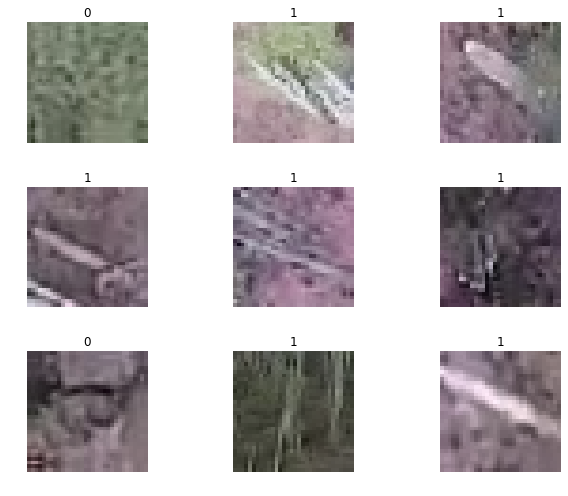

In [10]:
data.show_batch(rows=3, figsize=(9,7))

In [11]:
data.classes, data.c

([0, 1], 2)

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 47209673.20it/s]


In [13]:
learn.data.train_ds[0][0].shape

torch.Size([3, 32, 32])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


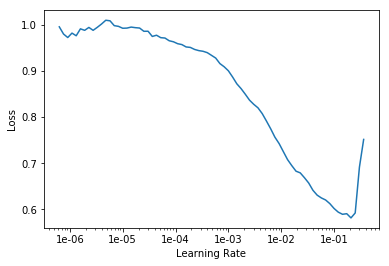

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(8, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.207876,0.149295,0.056286,00:28
1,0.131606,0.089583,0.029714,00:25
2,0.089302,0.040325,0.016000,00:23
3,0.053512,0.043650,0.016857,00:25
4,0.037975,0.029484,0.010000,00:23
5,0.032259,0.026484,0.010286,00:23
6,0.033688,0.035075,0.009714,00:25
7,0.026943,0.044754,0.012000,00:23


In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

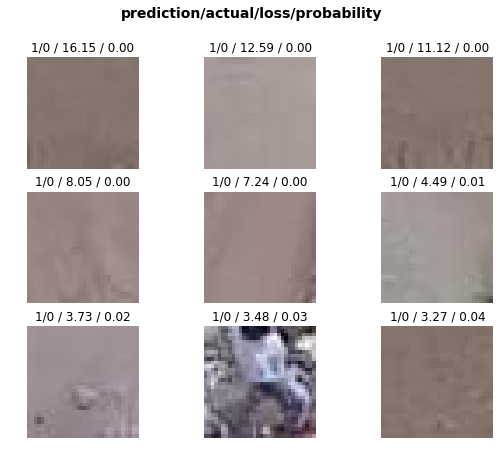

In [17]:
interp.plot_top_losses(9, figsize=(9,7))

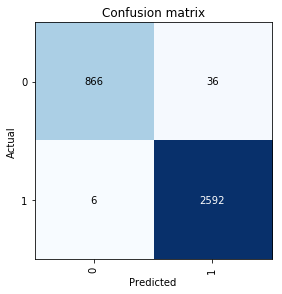

In [18]:
interp.plot_confusion_matrix()

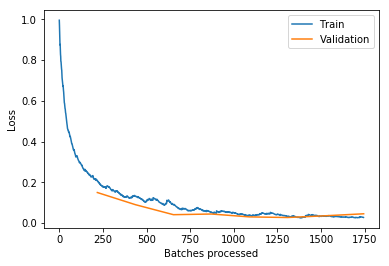

In [19]:
learn.recorder.plot_losses()

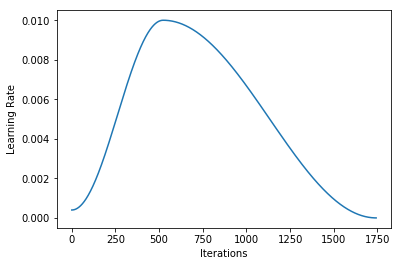

In [20]:
learn.recorder.plot_lr()

In [21]:
learn.save('stage-1')

In [23]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


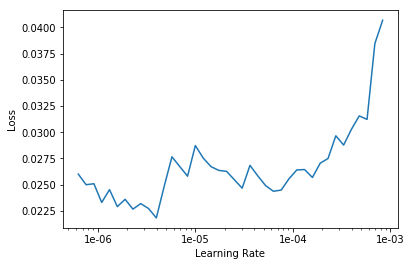

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(4, slice(1e-5/2))

epoch,train_loss,valid_loss,error_rate,time
0,0.027352,0.057827,0.012857,00:24
1,0.029076,0.055469,0.012857,00:26
2,0.028199,0.049572,0.013429,00:24
3,0.022752,0.027116,0.010571,00:24


In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

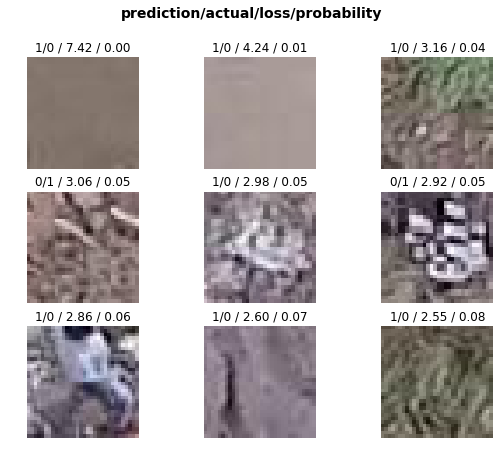

In [29]:
interp.plot_top_losses(9, figsize=(9,7))

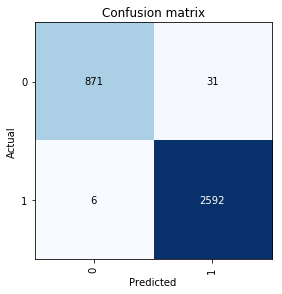

In [30]:
interp.plot_confusion_matrix()

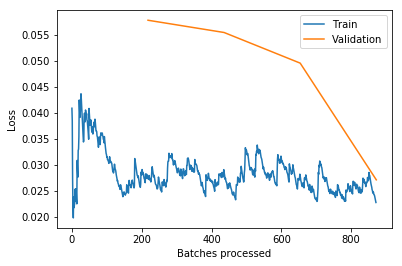

In [31]:
learn.recorder.plot_losses()

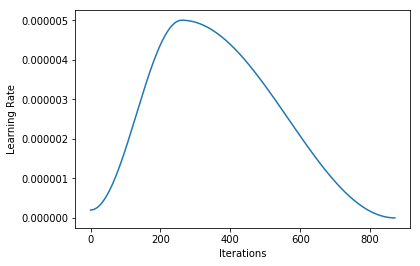

In [32]:
learn.recorder.plot_lr()

In [33]:
learn.save('stage-2')

In [43]:
tfms=get_transforms(flip_vert=True)
data64 = (src.transform(tfms, size=64)
          .databunch()
          .normalize(imagenet_stats))

In [44]:
learn.data = data64

In [45]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


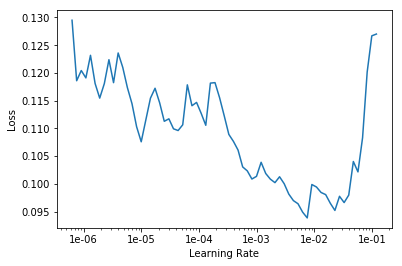

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(4, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.049672,0.020808,0.005714,00:29
1,0.034824,0.013776,0.006000,00:29
2,0.019700,0.011506,0.004000,00:28
3,0.022139,0.010020,0.003429,00:29


In [48]:
learn.fit_one_cycle(4, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.031065,0.008478,0.003143,00:27
1,0.026798,0.008474,0.002857,00:29
2,0.013488,0.009150,0.002286,00:27
3,0.010758,0.007452,0.002571,00:28


In [49]:
learn.fit_one_cycle(4, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.021081,0.007696,0.002857,00:28
1,0.015294,0.018904,0.004857,00:27
2,0.014240,0.006431,0.002286,00:29
3,0.013129,0.008270,0.002857,00:28


In [50]:
learn.fit_one_cycle(4, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.018777,0.006754,0.002857,00:28
1,0.023789,0.010374,0.003714,00:29
2,0.013129,0.007032,0.003143,00:28
3,0.011772,0.006996,0.002857,00:28


In [51]:
learn.fit_one_cycle(4, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.014033,0.010074,0.002857,00:27
1,0.015488,0.009071,0.003143,00:29
2,0.010021,0.008053,0.002857,00:29
3,0.006178,0.007362,0.002857,00:28


In [52]:
learn.fit_one_cycle(4, slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.014735,0.014680,0.005429,00:27
1,0.011657,0.012198,0.003143,00:29
2,0.007973,0.008834,0.003429,00:27
3,0.004676,0.008771,0.002857,00:28


In [53]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

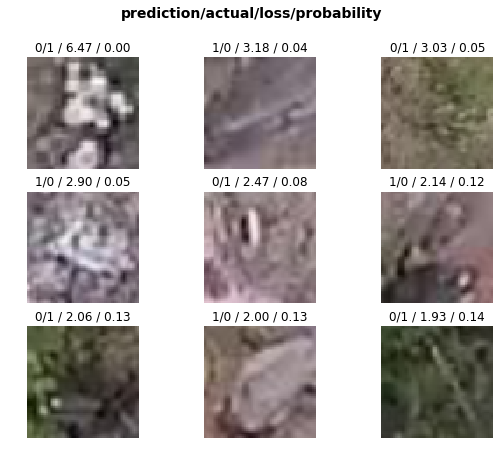

In [54]:
interp.plot_top_losses(9, figsize=(9,7))

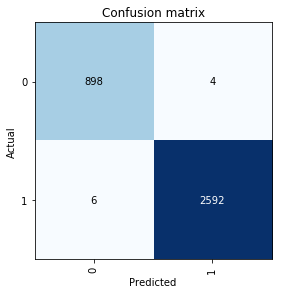

In [55]:
interp.plot_confusion_matrix()

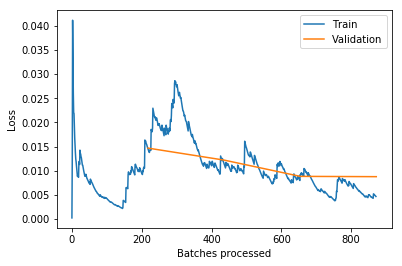

In [56]:
learn.recorder.plot_losses()

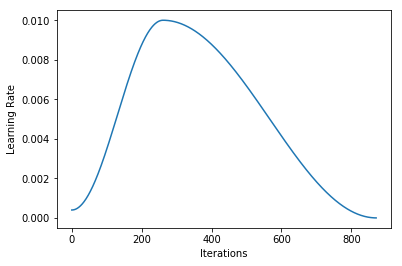

In [57]:
learn.recorder.plot_lr()

In [58]:
learn.save('stage-3')

In [67]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


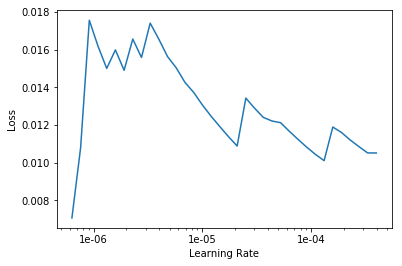

In [68]:
learn.lr_find()
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(4, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.018564,0.029706,0.006286,00:30
1,0.014525,0.011384,0.004000,00:28
2,0.013934,0.006340,0.002286,00:30
3,0.004630,0.009200,0.003143,00:29


In [70]:
learn.fit_one_cycle(4, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.008752,0.011039,0.003429,00:29
1,0.010731,0.009910,0.002571,00:29
2,0.004703,0.008443,0.002571,00:29
3,0.003933,0.009177,0.002857,00:30


In [71]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

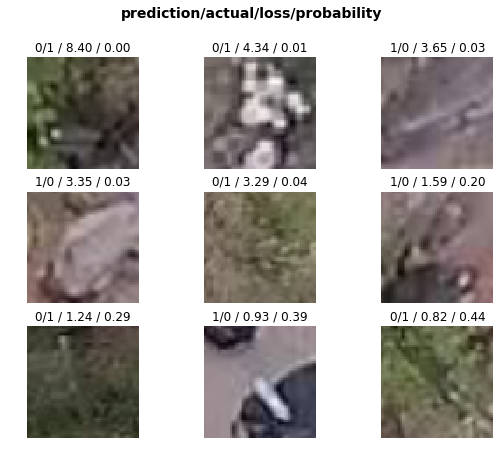

In [72]:
interp.plot_top_losses(9, figsize=(9,7))

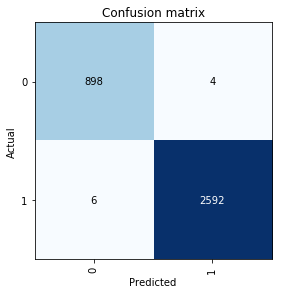

In [73]:
interp.plot_confusion_matrix()

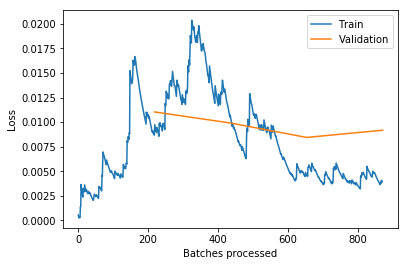

In [74]:
learn.recorder.plot_losses()

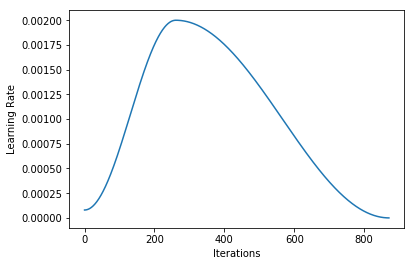

In [75]:
learn.recorder.plot_lr()

In [76]:
learn.save('stage-4')

In [77]:
learn.export("/export.pkl")

In [78]:
predictor = load_learner("/", test=ImageList.from_df(df, path))

In [79]:
preds_train, y_train, losses_train  = predictor.get_preds(ds_type=DatasetType.Test, with_loss=True)
preds_train[:5], y_train[:5], losses_train[:5]

(tensor([[3.9235e-13, 1.0000e+00],
         [1.1063e-06, 1.0000e+00],
         [1.0212e-12, 1.0000e+00],
         [3.1008e-06, 1.0000e+00],
         [4.4521e-07, 1.0000e+00]]),
 tensor([0, 0, 0, 0, 0]),
 tensor([28.5666, 13.7145, 27.6101, 12.6838, 14.6247]))

In [80]:
y_train = torch.argmax(preds_train, dim=1)

In [81]:
interp = ClassificationInterpretation(predictor, preds_train, tensor(df.has_cactus.values), losses_train)

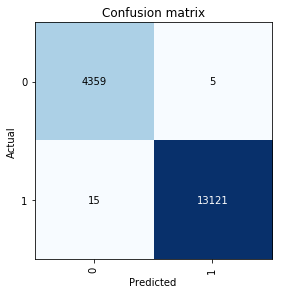

In [82]:
interp.plot_confusion_matrix()

In [83]:
from sklearn.metrics import roc_auc_score
def roc_auc(y_pred, y_true):
    return roc_auc_score(y_true, y_pred)

In [84]:
roc_auc(y_train, df.has_cactus.values)

0.9988561810115094

In [85]:
predictor = load_learner("/", test=ImageList.from_folder(path/'test/test'))

In [86]:
preds_test, y_test, losses_test  = predictor.get_preds(ds_type=DatasetType.Test, with_loss=True)
preds_test[:5], y_test[:5], losses_test[:5]

(tensor([[2.8863e-04, 9.9971e-01],
         [7.8936e-06, 9.9999e-01],
         [3.6821e-07, 1.0000e+00],
         [3.6276e-06, 1.0000e+00],
         [5.7587e-10, 1.0000e+00]]),
 tensor([0, 0, 0, 0, 0]),
 tensor([ 8.1504, 11.7495, 14.8146, 12.5269, 21.2751]))

In [87]:
y_test = torch.argmax(preds_test, dim=1)
y_test

tensor([1, 1, 1,  ..., 1, 0, 1])

In [88]:
sub_df = pd.DataFrame({'id': os.listdir(path/'test/test'), 
                         'has_cactus': y_test})

In [89]:
sub_df.head()

,id,has_cactus
0,79ac4cc3b082e0a1defe1be601806efd.jpg,1
1,e880364d6521c6f3a27748ec62b0e335.jpg,1
2,74912492b6cdf28c4bfb9c8e1d35af3e.jpg,1
3,078cfa961183b30693ea2f13f5ff6d17.jpg,1
4,7fd729184ef182899ce3e7a174fb9bc0.jpg,1


In [90]:
sub_df.to_csv('submission-v2.csv', index=False)